In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/IMDB_RESULTS

/content/drive/MyDrive/IMDB_RESULTS


# **Parameters Setting**

In [3]:
maxlen = 100
latent_dim = 10
manifold_dim = 5
epochs = 10

In [4]:
from importlib import reload
import sys
import numpy as np
from imp import reload
import warnings

warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

In [5]:
import pandas as pd
df1 = pd.read_csv('labeledTrainData.tsv.zip', delimiter="\t")
df1 = df1.drop(['id'], axis=1)
df1.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [6]:
df2 = pd.read_csv('imdb_master.csv',encoding="latin-1")
df2.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [7]:
df2 = df2.drop(['Unnamed: 0','type','file'],axis=1)
df2.columns = ["review","sentiment"]
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [8]:
df2 = df2[df2.sentiment != 'unsup']
df2['sentiment'] = df2['sentiment'].map({'pos': 1, 'neg': 0})
df2.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [9]:
df = pd.concat([df1, df2]).reset_index(drop=True)
df.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [10]:
df['sentiment'].value_counts()


sentiment
1    37500
0    37500
Name: count, dtype: int64

# **Text Preprocessing**

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['Processed_Reviews'] = df.review.apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
df.head()

,sentiment,review,Processed_Reviews
0,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [13]:
df.Processed_Reviews.apply(lambda x: len(x.split(" "))).mean()

128.51009333333334

# **Text Embedding**

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_features = 6000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])

x_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
y_train = df['sentiment']

In [15]:
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18894 sha256=dfb0c4cd8e2b1631cf20ff48df9f55aaf237031f39100ae860820b1c4333837e
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# **Global Dimention Reduction with Trasformers**

In [16]:
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D,LayerNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import keras
from keras_self_attention  import SeqSelfAttention # Self attention

input = Input(shape=(maxlen,))
x = Embedding(max_features, maxlen)(input)
x = Bidirectional(LSTM(128, return_sequences = True))(x)
x = SeqSelfAttention(units = 128, attention_width= 5,
                           attention_type = SeqSelfAttention.ATTENTION_TYPE_MUL,
                           return_attention = False,
                           kernel_initializer = 'glorot_normal', bias_initializer= 'zeros',
                           kernel_regularizer = None, bias_regularizer = None,
                           kernel_constraint= None, bias_constraint= None,
                           use_additive_bias= True,
                           use_attention_bias = True, attention_activation = 'relu',
                           attention_regularizer_weight = 0)(x)
x = GlobalMaxPool1D()(x)
x = Dense(latent_dim, activation="relu")(x)
bottleneck = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(bottleneck)

model = keras.Model(inputs=input, outputs=output)
encoder = Model(inputs = model.input, outputs = bottleneck)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
history = model.fit(x_train,y_train, batch_size=maxlen, epochs=epochs, validation_split=0.2,callbacks = [callback])

Epoch 1/10
600/600 [==============================] - 57s 85ms/step - loss: 0.3994 - accuracy: 0.8188 - val_loss: 0.2890 - val_accuracy: 0.9011
Epoch 2/10
600/600 [==============================] - 18s 30ms/step - loss: 0.2787 - accuracy: 0.8985 - val_loss: 0.2541 - val_accuracy: 0.9183
Epoch 3/10
600/600 [==============================] - 16s 26ms/step - loss: 0.2321 - accuracy: 0.9205 - val_loss: 0.2621 - val_accuracy: 0.9027
Epoch 4/10
600/600 [==============================] - 14s 22ms/step - loss: 0.1943 - accuracy: 0.9355 - val_loss: 0.1779 - val_accuracy: 0.9415
Epoch 5/10
600/600 [==============================] - 14s 23ms/step - loss: 0.1664 - accuracy: 0.9471 - val_loss: 0.1227 - val_accuracy: 0.9641
Epoch 6/10
600/600 [==============================] - 13s 22ms/step - loss: 0.1354 - accuracy: 0.9597 - val_loss: 0.1116 - val_accuracy: 0.9709
Epoch 7/10
600/600 [==============================] - 13s 21ms/step - loss: 0.1081 - accuracy: 0.9690 - val_loss: 0.0801 - val_accuracy:

# **Summary of deep model (Trainable and NonTrainable parameters)**

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          600000    
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          234496    
 al)                                                             
                                                                 
 seq_self_attention (SeqSel  (None, 100, 256)          65537     
 fAttention)                                                     
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                             

# **Convergence behavir of the Encoder-Decoder model**

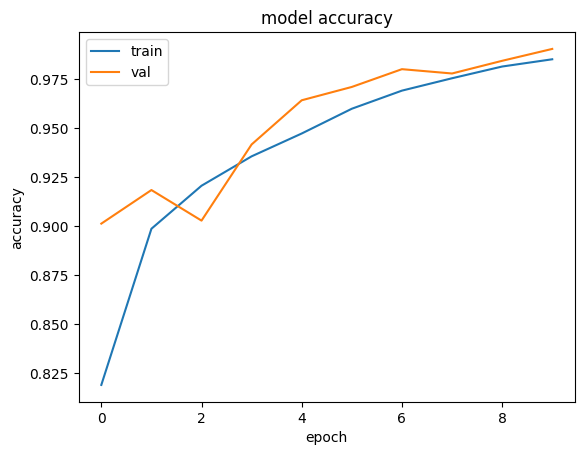

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

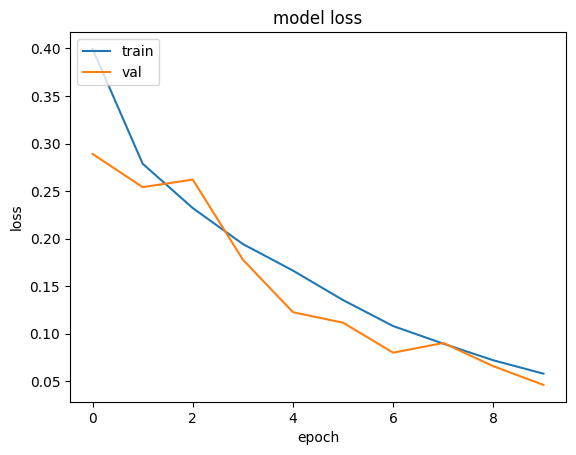

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
df_test=pd.read_csv("testData.tsv.zip",header=0, delimiter="\t", quoting=3)
df_test.head()
df_test["review"]=df_test.review.apply(lambda x: clean_text(x))
df_test["sentiment"] = df_test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)
y_test = df_test["sentiment"]
list_sentences_test = df_test["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
x_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
y_pred = model.predict(x_test)
y_pred = np.where(y_pred>0.55,1,0)

782/782 [==============================] - 5s 5ms/step


# **Plot the structure of the encoder model**

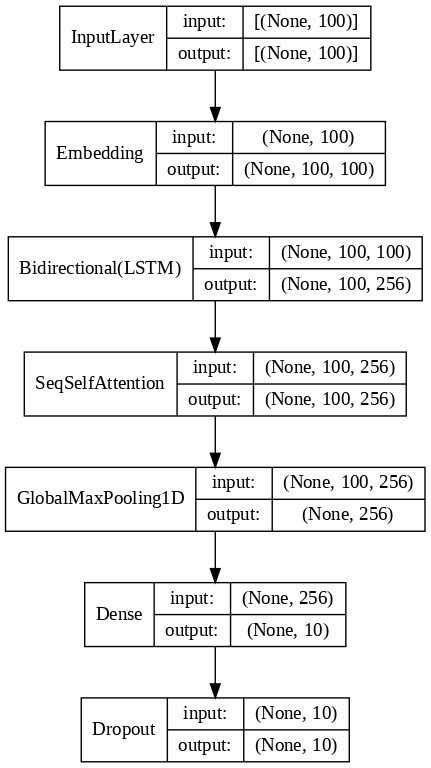

In [21]:
keras.utils.plot_model(
    encoder,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
    show_layer_activations=False,
    show_trainable=False,
)

In [22]:
x_encoded_train = encoder.predict(x_train)
x_encoded_test = encoder.predict(x_test)
print(x_encoded_train.shape, x_encoded_test.shape)

782/782 [==============================] - 4s 5ms/step
(75000, 10) (25000, 10)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
 f1_score, confusion_matrix, classification_report)

# manifold **SpectralEmbedding**

In [24]:
from sklearn.manifold import SpectralEmbedding

x_new_train = SpectralEmbedding(n_components=manifold_dim, n_neighbors=50, random_state=42).fit_transform(x_encoded_train)
x_new_test = SpectralEmbedding(n_components=manifold_dim, n_neighbors=50, random_state=42).fit_transform(x_encoded_test)

print('--------------------------Results for manifold dimention-------------------')

model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

print('--------------------------Results for 3d dimention-------------------')

x_new_train = SpectralEmbedding(n_components=3, n_neighbors=50, random_state=42).fit_transform(x_encoded_train)
x_new_test = SpectralEmbedding(n_components=3, n_neighbors=50, random_state=42).fit_transform(x_encoded_test)

model = RandomForestClassifier().fit(x_new_train, y_train)
y_pred = model.predict(x_new_test)
y_pred = np.where(y_pred>0.55,1,0)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test,y_pred)
cm = pd.DataFrame(cm , index=['0','1'] , columns=['0','1'])
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor='black', annot=True, fmt='')

y_test = np.array(y_test)
fig = plt.figure()
ax = plt.axes(projection ='3d')
for i in range(len(y_test)):
    ax.scatter(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
    ax.plot3D(x_new_test[i,0],x_new_test[i,1],x_new_test[i,2], c = 'r' if y_test[i]==1 else 'b')
ax.set_title('3D plot for IMDB dataset')
plt.show()


KeyboardInterrupt: 